In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
train_path = "./Data/Data_src1/train"
valid_path = "./Data/Data_src1/valid"
test_path = "./Data/Data_src1/test"

In [3]:
# Transformaitions on training set 'image augmentation' - prevent overfitting (high accuracy on training set but not on test set) 
# ImageDataGenerator - generate batches of real time data (e.g. 32 images) - applies augmentation - e.g. zoom range, shear range, horizontal flip, rescale i.e. feature scaling (0-255 here)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# flow from directory connects to directory
# Resizing images to make the model faster
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 30250 images belonging to 2 classes.


In [4]:
# No transformations for test images, but requires feature scaling
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_set = validation_datagen.flow_from_directory(valid_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 6300 images belonging to 2 classes.


In [5]:
# No transformations for test images, but requires feature scaling
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 6300 images belonging to 2 classes.


CNN DEFINITION

In [6]:
# Initializing
cnn = tf.keras.models.Sequential()

In [7]:
# Convolution
# filters = kernels, activation = relu, input shape = 64x64, 3 (rgb)
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(64,64,3)))

In [8]:
# Pooling
# Pool size = 2,2 (frame size), stride = 2 (# pixels frame shifts to right)
# padding = 'valid' (ignore) OR same (add empty pixels to make the frame complete)
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [9]:
# Second convolutional layer
# No insput shape parameter required in second layer
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [10]:
# Third convolutional layer
# No insput shape parameter required in second layer
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [11]:
# Flattening
# Put results in 1D vector
cnn.add(tf.keras.layers.Flatten())

In [12]:
# Full connection
cnn.add(tf.keras.layers.Dense(units=128,activation='relu'))

In [13]:
# Output layer
cnn.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

In [18]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 32)         0

CNN TRAINING

In [19]:
# compile - stochastic gradient optimizer - binary cross entropy loss - accuracy
cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

In [20]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

In [21]:
# train and evaluate
# cnn.fit(x=training_set, validation_data=validation_set, epochs=25)
history = cnn.fit(x=training_set, validation_data=validation_set, epochs=30)

Epoch 1/30
946/946 [==============================] - 531s 560ms/step - loss: 0.2308 - accuracy: 0.9060 - val_loss: 0.4053 - val_accuracy: 0.8592
Epoch 2/30
946/946 [==============================] - 164s 173ms/step - loss: 0.1707 - accuracy: 0.9356 - val_loss: 0.3234 - val_accuracy: 0.8876
Epoch 3/30
946/946 [==============================] - 150s 158ms/step - loss: 0.1636 - accuracy: 0.9388 - val_loss: 0.1367 - val_accuracy: 0.9478
Epoch 4/30
946/946 [==============================] - 133s 141ms/step - loss: 0.1573 - accuracy: 0.9392 - val_loss: 0.2129 - val_accuracy: 0.9214
Epoch 5/30
946/946 [==============================] - 124s 131ms/step - loss: 0.1498 - accuracy: 0.9427 - val_loss: 0.1321 - val_accuracy: 0.9494
Epoch 6/30
946/946 [==============================] - 132s 139ms/step - loss: 0.1434 - accuracy: 0.9449 - val_loss: 0.1641 - val_accuracy: 0.9424
Epoch 7/30
946/946 [==============================] - 124s 131ms/step - loss: 0.1412 - accuracy: 0.9469 - val_loss: 0.1374 -

In [22]:
cnn.save('saved_model/cnn_30epochs_adam_bincross')

INFO:tensorflow:Assets written to: saved_model/cnn_30epochs_adam_bincross\assets


INFO:tensorflow:Assets written to: saved_model/cnn_30epochs_adam_bincross\assets


INFERENCE

In [23]:
training_set.class_indices

{'nowildfire': 0, 'wildfire': 1}

In [84]:
cnn = tf.keras.models.load_model('saved_model/cnn_30epochs_adam_bincross')

In [85]:
import numpy as np
import keras.utils as image

image_path=test_path+'/wildfire/-59.03238,51.85132.jpg'
test_image = image.load_img(image_path, target_size=(64,64)) #img size must be 64x64
test_image = image.img_to_array(test_image) #should be an array
test_image = np.expand_dims(test_image,axis=0) #must be an batch - so adding extra dimension
result = cnn.predict(test_image/255.0) #must normalize the test image

# inside a batch [0], first prediction [0]
if result[0][0] > 0.5:
    prediction = 'wildfire'
else:
    prediction = 'no wildfire'

1/1 [==============================] - 0s 214ms/step


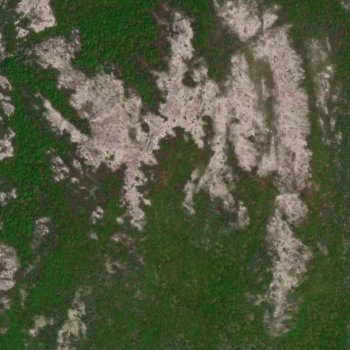

0.5701346
wildfire


In [86]:
from IPython.display import Image, display
display(Image(filename=image_path))
print(result[0][0])
print(prediction)

VISUALIZE LAYERS

In [87]:
print("image shape", test_image.shape)

layer_outputs = [layer.output for layer in cnn.layers[:8]]
activation_model = tf.keras.models.Model(inputs=cnn.input, outputs=layer_outputs)
activations = cnn.predict(test_image)

conv_indices = []
for i in range(len(result)):
    if( "conv2d" in cnn.layers[i].name) :
        conv_indices.append(i)
        print("Layer: ", cnn.layers[i].name, " Shape: ", result[i].shape)

image shape (1, 64, 64, 3)
1/1 [==============================] - 0s 61ms/step
Layer:  conv2d  Shape:  (1,)


1/1 [==============================] - 0s 347ms/step
(1, 31, 31, 32)
(1, 29, 29, 32)
(1, 14, 14, 32)
(1, 12, 12, 32)
(1, 6, 6, 32)
(1, 1152)

c:\Users\wwinnie\AppData\Local\anaconda3\envs\venv-wildfire\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide



(1, 128)
(1, 1)


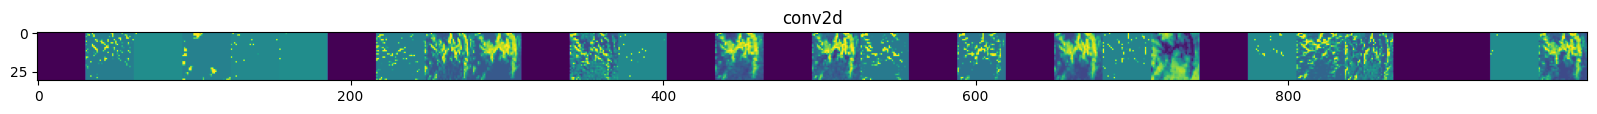

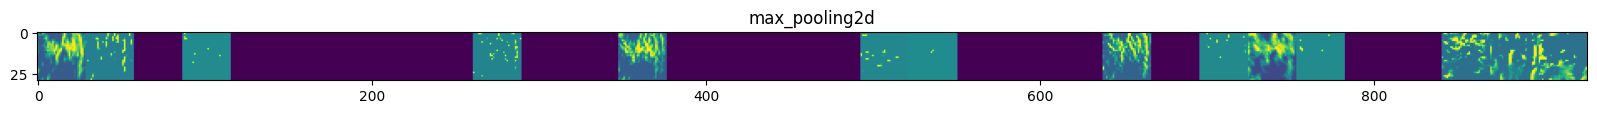

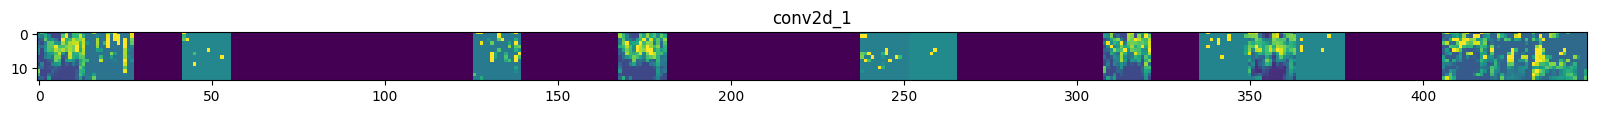

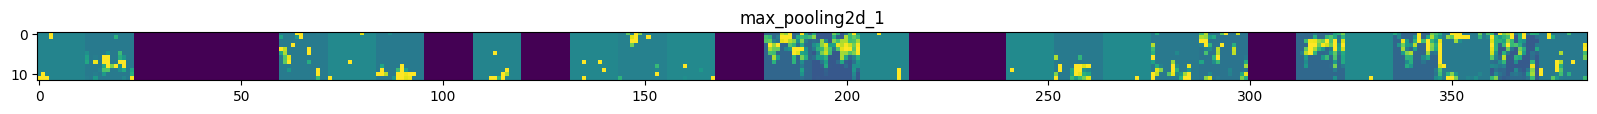

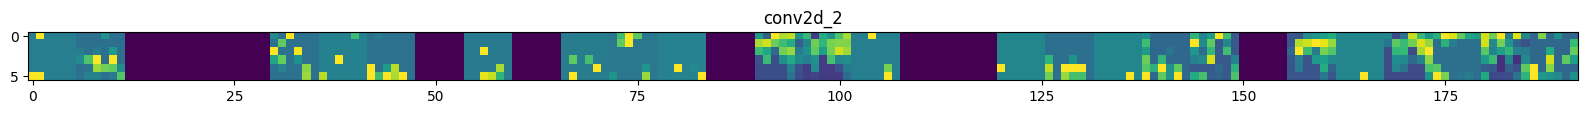

In [88]:
import matplotlib.pyplot as plt

successive_outputs = [layer.output for layer in cnn.layers[1:]]#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = cnn.input, outputs = successive_outputs)#Load the input image


successive_feature_maps = visualization_model.predict(test_image)# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in cnn.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

INFERENCE BATCH

In [89]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

In [90]:
result = cnn.predict(test_set) 

197/197 [==============================] - 31s 156ms/step


In [91]:
print(result)

[[9.9975669e-01]
 [9.6837789e-01]
 [9.9944222e-01]
 ...
 [9.9875474e-01]
 [7.5221699e-01]
 [4.5706406e-06]]


In [92]:
import re

image_paths = test_set.filenames
results_disp = result[:5]
result_formatted = []

for i in range(len(result)):
    if result[i][0] >= 0.5:
        prediction_label = 'wildfire'
    else:
        prediction_label = 'no wildfire'

    result_obj = {
        "image_path": test_path + "/" + re.sub(r'\\', '/', image_paths[i]),
        "prediction": result[i],
        "prediction_label":prediction_label
    }
    
    # display(Image(filename=result_obj['image_path']))
    # print("Image Path:", result_obj['image_path'])
    # print("Prediction:", result_obj['prediction'])
    # print("Prediction Label:", result_obj['prediction_label'])

    result_formatted.append(result_obj)

In [93]:
import pandas as pd
output_file = './model_predictions/cnn_30epochs_adam_bincross/result_formatted.csv'
df = pd.DataFrame(result_formatted)
df.to_csv(output_file)

EVALUATION & ACCURACY

In [94]:
# cnn = tf.keras.models.load_model('saved_model/cnn_25epochs_adam_bincross')

In [95]:
df = pd.read_csv('./model_predictions/cnn_30epochs_adam_bincross/result_formatted.csv')

In [96]:
df['label_bool'] = df['image_path'].apply(lambda path: 1 if '/test/wildfire/' in path else 0)
df['prediction_label_bool'] = df['prediction_label'].apply(lambda label: 1 if label == 'wildfire' else 0)

In [97]:
df.head(3)

,Unnamed: 0,image_path,prediction,prediction_label,label_bool,prediction_label_bool
0,0,"./Data/Data_src1/test/nowildfire/-113.91777,50...",[0.9997567],wildfire,0,1
1,1,"./Data/Data_src1/test/nowildfire/-113.91782,50...",[0.9683779],wildfire,0,1
2,2,"./Data/Data_src1/test/nowildfire/-113.91793,51...",[0.9994422],wildfire,0,1


In [98]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

In [99]:
loss, accuracy = cnn.evaluate(test_set, verbose=1)
loss_v, accuracy_v = cnn.evaluate(validation_set, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

197/197 [==============================] - 34s 171ms/step - loss: 0.1435 - accuracy: 0.9533
Validation: accuracy = 0.953333  ;  loss_v = 0.143485
Test: accuracy = 0.959683  ;  loss = 0.135883


Asked chat GPT to generate code for some stuff below :P lets see..

In [100]:
import matplotlib.pyplot as plt

def plot_model_history(history):
    # Retrieve the training metrics from the history object
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    # Retrieve the validation metrics if available
    if 'val_loss' in history.history and 'val_accuracy' in history.history:
        val_loss = history.history['val_loss']
        val_accuracy = history.history['val_accuracy']

        # Plot training and validation metrics
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy, label='Training Accuracy')
        plt.plot(val_accuracy, label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    else:
        # Plot only the training metrics if validation metrics are not available
        plt.figure(figsize=(6, 4))
        plt.plot(train_loss, label='Training Loss')
        plt.plot(train_accuracy, label='Training Accuracy')
        plt.title('Training Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()

    plt.tight_layout()
    plt.show()

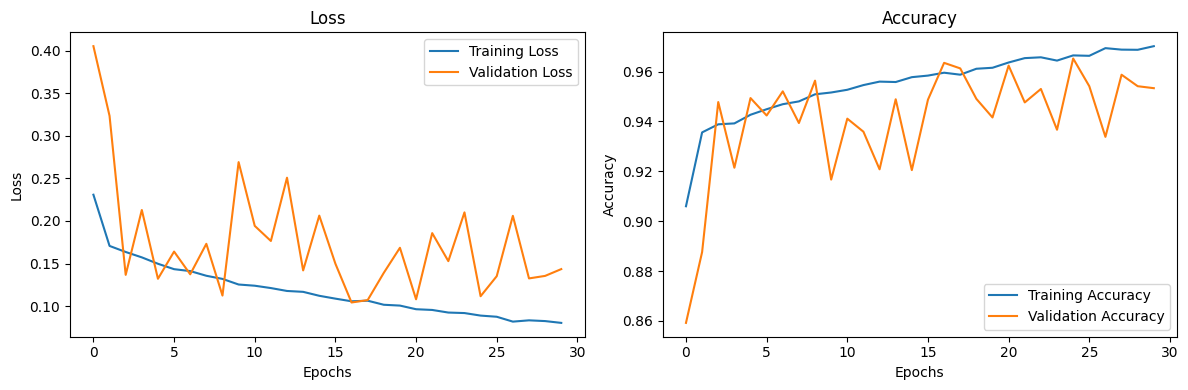

In [101]:
plot_model_history(history)

In [102]:

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

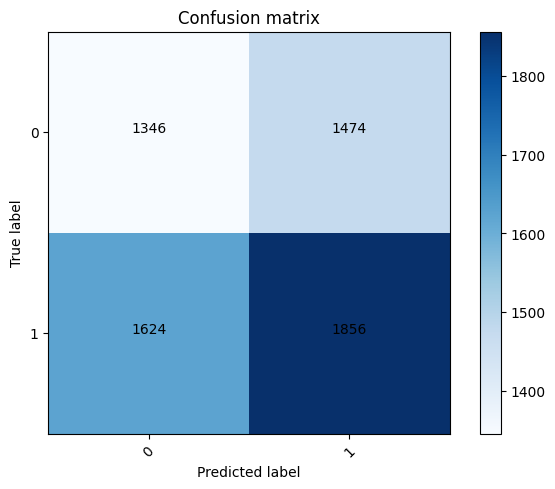

In [103]:
pred = df['prediction_label_bool']
label = df['label_bool']
confusion_mtx = confusion_matrix(label, pred)
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

Text(0, 0.5, 'Fraction classified incorrectly')

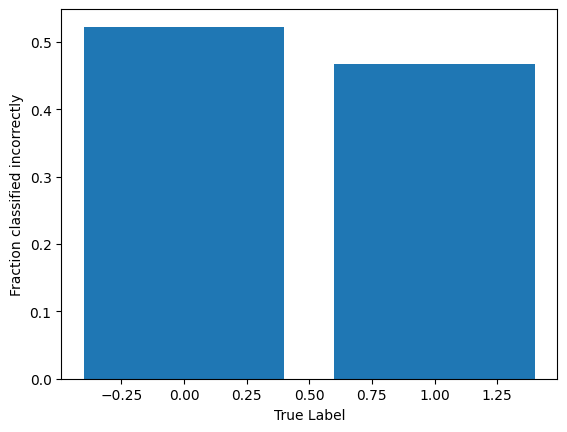

In [104]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(2),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')